In [1]:
# paper link: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi =  { s: i + 1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i:s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [30]:
# build the dataset
block_size = 3 # context length: how many characters do take to predict the next one
X, Y = [], []

for w in words[:5]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [31]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [64]:
def build_dataset(words):
    # build the dataset
    block_size = 3 # context length: how many characters do take to predict the next one
    X, Y = [], []
    
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of total parameters

for p in parameters:
    p.requires_grad = True

In [80]:
# trying different learning rates to find best (see track stats section in next block)
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [87]:
lri = []
lossi = []
stepi = []

for i in range(60000):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # shape=[32, 3, 2]
    
    # torch.cat(torch.unbind(emb, 1), 1).shape
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 -> pytorch will derive '32', shape=(32, 100)
    logits = h @ W2 + b2 # (32, 27)
    
    # F.cross_entropy equivalent to:
    #   counts = logits.exp()
    #   prob = counts / counts.sum(1, keepdims=True)
    #   loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    #lr = lrs[i]
    lr = 0.01 # good learning rate through experimenting with different rates (see track stats section below)
    # lr = 0.01 # switch to lower learning rate to find optimal solution (called learning rate decay)
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.item())

print(loss.item())
#plt.plot(lri, lossi)

1.9849305152893066


In [89]:
# evaluate loss over all samples
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 -> pytorch will derive '32', shape=(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1646, grad_fn=<NllLossBackward0>)

In [88]:
# evaluate loss over all samples
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 -> pytorch will derive '32', shape=(32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1994, grad_fn=<NllLossBackward0>)

In [35]:
# training split (80%), dev/validation split (10%), test split (10%)

# the dev/validation split is used for developing the hyperparameters of the model (ex.: size of hidden layer,
# size of the embedding layer, etc.)

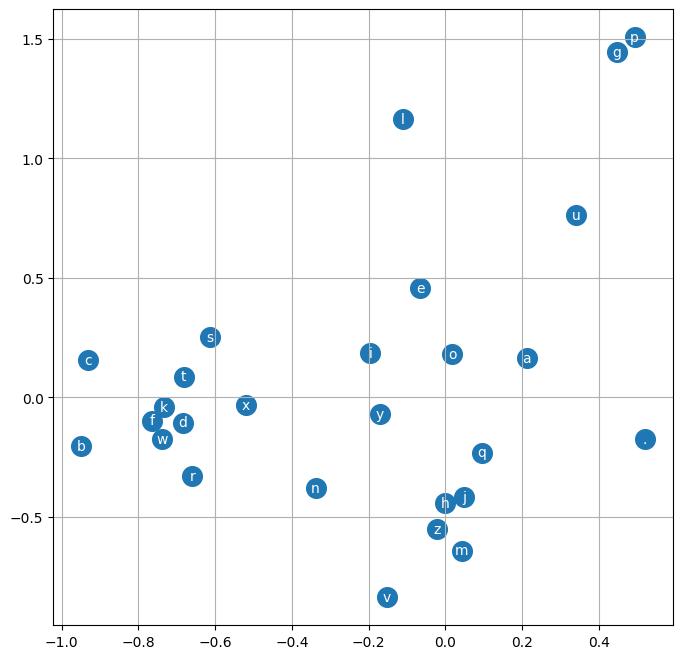

In [78]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [90]:
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all zeros
    while(True):
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if(ix == 0):
            break

    print(''.join(itos[i] for i in out))

kaliigaanh.
mehemmaley.
alen.
lynn.
azla.
tylee.
rolberlyn.
emmiia.
sararalyrehkairo.
jahmurasen.
ambirxa.
zustameer.
malayse.
josephon.
dmaryezenemun.
keylissanosi.
yoannarth.
alee.
johnabig.
riamado.
